In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch import nn
from torch.nn import functional as F, BCELoss
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        """Encoder layers"""
        self.linear1 = nn.Linear(196, 128)
        self.linear2 = nn.Linear(128, 16)  
        """Decoder layers"""
        self.linear3 = nn.Linear(8, 128)
        self.linear4 = nn.Linear(128, 196)

    def encode(self, x):
        layer1 = torch.tanh(self.linear1(x))
        encoder_ouputs = self.linear2(layer1)
        mu = encoder_ouputs[:, :8]
        logsigma = encoder_ouputs[:, 8:]
        return mu, logsigma

    def reparameterize(self, mu, logsigma):
        std = torch.exp(0.5*logsigma)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, latent_factor):
        decodelayer1 = torch.tanh(self.linear3(latent_factor))
        return torch.sigmoid(self.linear4(decodelayer1))

    def forward(self, x):
        mu, logsigma = self.encode(x.view(-1, 196))
        latent_factor = self.reparameterize(mu, logsigma)
        return self.decode(latent_factor), mu, logsigma
    
def loss_function(recon_x, x, mu, logsigma):
    BCE_Loss = F.binary_cross_entropy(recon_x, x.view(-1, 196), reduction='sum')
    KL_Divergence = -0.5 * torch.sum(1 + logsigma - mu.pow(2) - logsigma.exp())
    return BCE_Loss, KL_Divergence

In [3]:
traindata = datasets.MNIST(root='./data', train=True, download=True)
valdataset = datasets.MNIST(root='./data', train=False, download=True)
balanced_train_data = []; balanced_train_targets = []
for i in range(10):
    labelimgs = [labelimage for labelimage, label in traindata if label == i][:1000]
    for image in labelimgs:
        image = (transforms.ToTensor()(image.resize((14,14)))>0.5).float()
        balanced_train_data.append(image)
    balanced_train_targets.append(torch.ones(len(labelimgs))*i)
balanced_train_data = torch.cat(balanced_train_data)
balanced_train_targets = torch.cat(balanced_train_targets)

valdata = []; valtargets = []
for image, label in valdataset:
    image = (transforms.ToTensor()(image.resize((14,14)))>0.5).float()
    valdata.append(image)
    valtargets.append(torch.tensor(label))
valdata = torch.cat(valdata)
valtargets = torch.tensor(valtargets)
valdataset.data = valdata
valdataset.targets = valtargets
print(balanced_train_data.shape, balanced_train_targets.shape)
print(valdata.shape, valtargets.shape)

torch.Size([10000, 14, 14]) torch.Size([10000])
torch.Size([10000, 14, 14]) torch.Size([10000])


In [4]:
VariationalAE = VAE()
optimizer = torch.optim.Adam(VariationalAE.parameters(), lr = 0.001, weight_decay=1e-5)
train_losses = []
BCE_losses = []
KLD_losses = []
epochs = 50
dataloader = DataLoader(list(zip(balanced_train_data, balanced_train_targets)), 
                        batch_size=32, shuffle=True)
for epoch in range(epochs):
    VariationalAE.train()
    train_loss = 0
    for _, (data, _) in enumerate(dataloader):
        optimizer.zero_grad()
        recon_batch, mu, logvar = VariationalAE(data)
        BCE_loss, KL_Divergence = loss_function(recon_batch, data, mu, logvar)
        loss = BCE_loss + KL_Divergence
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        BCE_losses.append(BCE_loss.item())
        KLD_losses.append(KL_Divergence.item())
    print(f'Epoch: {epoch+1}, Loss: {train_loss / len(dataloader.dataset):.3f}')
    train_losses.append(train_loss / len(dataloader.dataset))

Epoch: 1, Loss: 58.776
Epoch: 2, Loss: 44.897
Epoch: 3, Loss: 41.900
Epoch: 4, Loss: 40.554
Epoch: 5, Loss: 39.655
Epoch: 6, Loss: 38.977
Epoch: 7, Loss: 38.528
Epoch: 8, Loss: 38.038
Epoch: 9, Loss: 37.720
Epoch: 10, Loss: 37.271
Epoch: 11, Loss: 37.033
Epoch: 12, Loss: 36.719
Epoch: 13, Loss: 36.485
Epoch: 14, Loss: 36.232
Epoch: 15, Loss: 36.060
Epoch: 16, Loss: 35.865
Epoch: 17, Loss: 35.698
Epoch: 18, Loss: 35.537
Epoch: 19, Loss: 35.412
Epoch: 20, Loss: 35.301
Epoch: 21, Loss: 35.211
Epoch: 22, Loss: 35.012
Epoch: 23, Loss: 34.946
Epoch: 24, Loss: 34.889
Epoch: 25, Loss: 34.801
Epoch: 26, Loss: 34.724
Epoch: 27, Loss: 34.600
Epoch: 28, Loss: 34.493
Epoch: 29, Loss: 34.495
Epoch: 30, Loss: 34.388
Epoch: 31, Loss: 34.301
Epoch: 32, Loss: 34.263
Epoch: 33, Loss: 34.207
Epoch: 34, Loss: 34.149
Epoch: 35, Loss: 34.052
Epoch: 36, Loss: 34.002
Epoch: 37, Loss: 33.942
Epoch: 38, Loss: 33.884
Epoch: 39, Loss: 33.850
Epoch: 40, Loss: 33.850
Epoch: 41, Loss: 33.800
Epoch: 42, Loss: 33.732
E

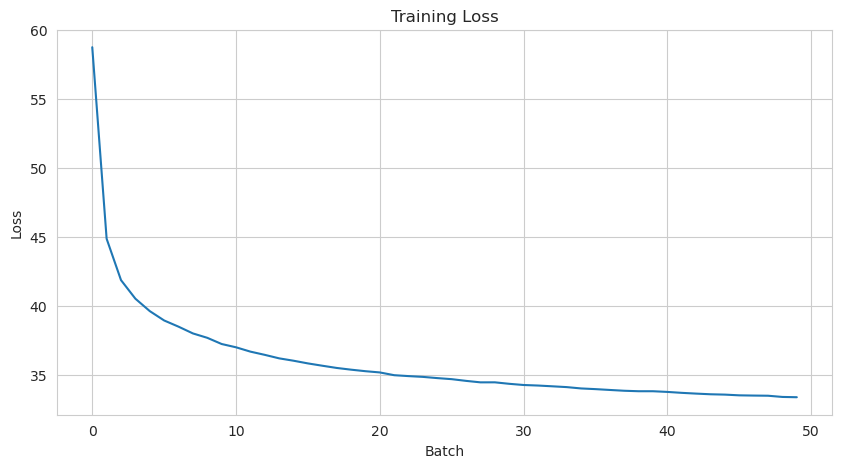

In [5]:

plt.figure(figsize=(10, 5))
sns.set_style("whitegrid")  # Set seaborn style
plt.plot(train_losses)
plt.title("Training Loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.savefig("Training_Loss.png")
plt.show()

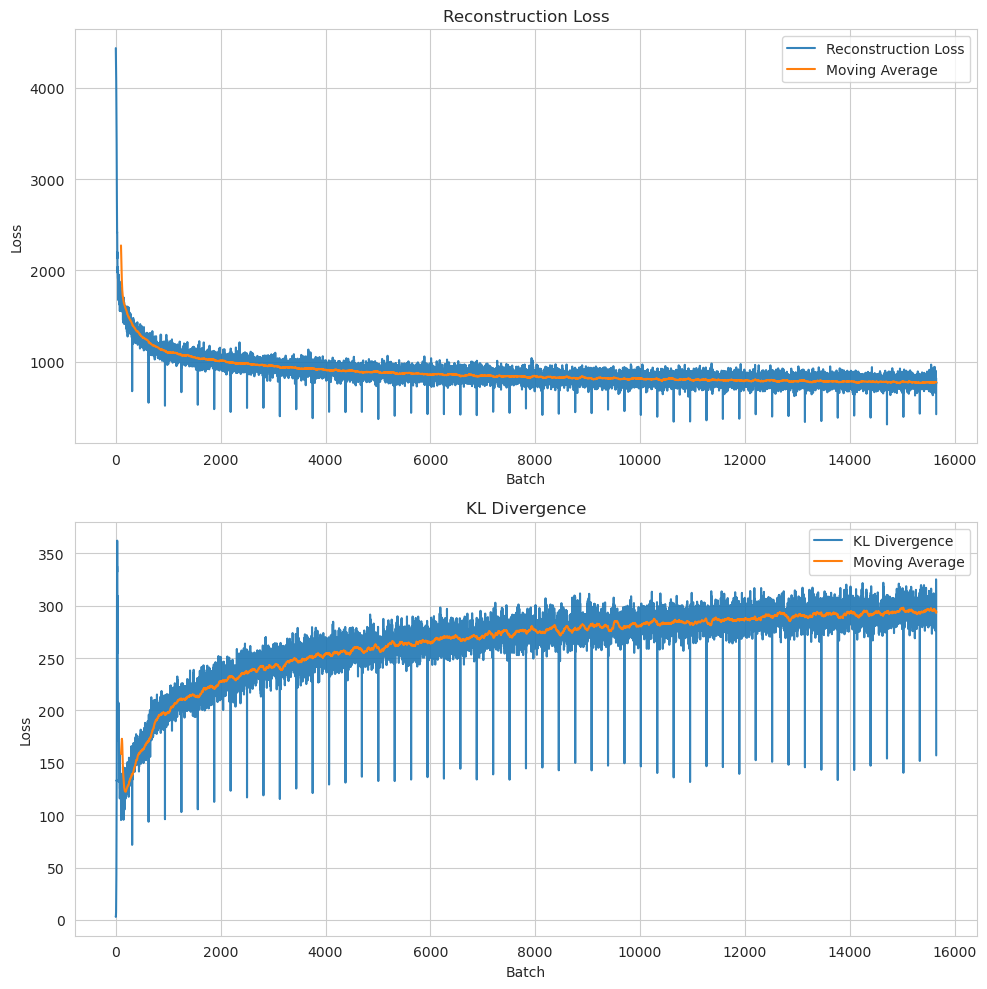

In [6]:
import pandas as pd
import seaborn as sns
plt.figure(figsize=(10, 10))
sns.set_style("whitegrid")

plt.subplot(2, 1, 1)
plt.plot(BCE_losses, label='Reconstruction Loss', alpha=0.9)
plt.plot(pd.Series(BCE_losses).rolling(window=100).mean(), label='Moving Average')
plt.title("Reconstruction Loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(KLD_losses, label='KL Divergence', alpha=0.9)
plt.plot(pd.Series(KLD_losses).rolling(window=100).mean(), label='Moving Average')
plt.title("KL Divergence")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

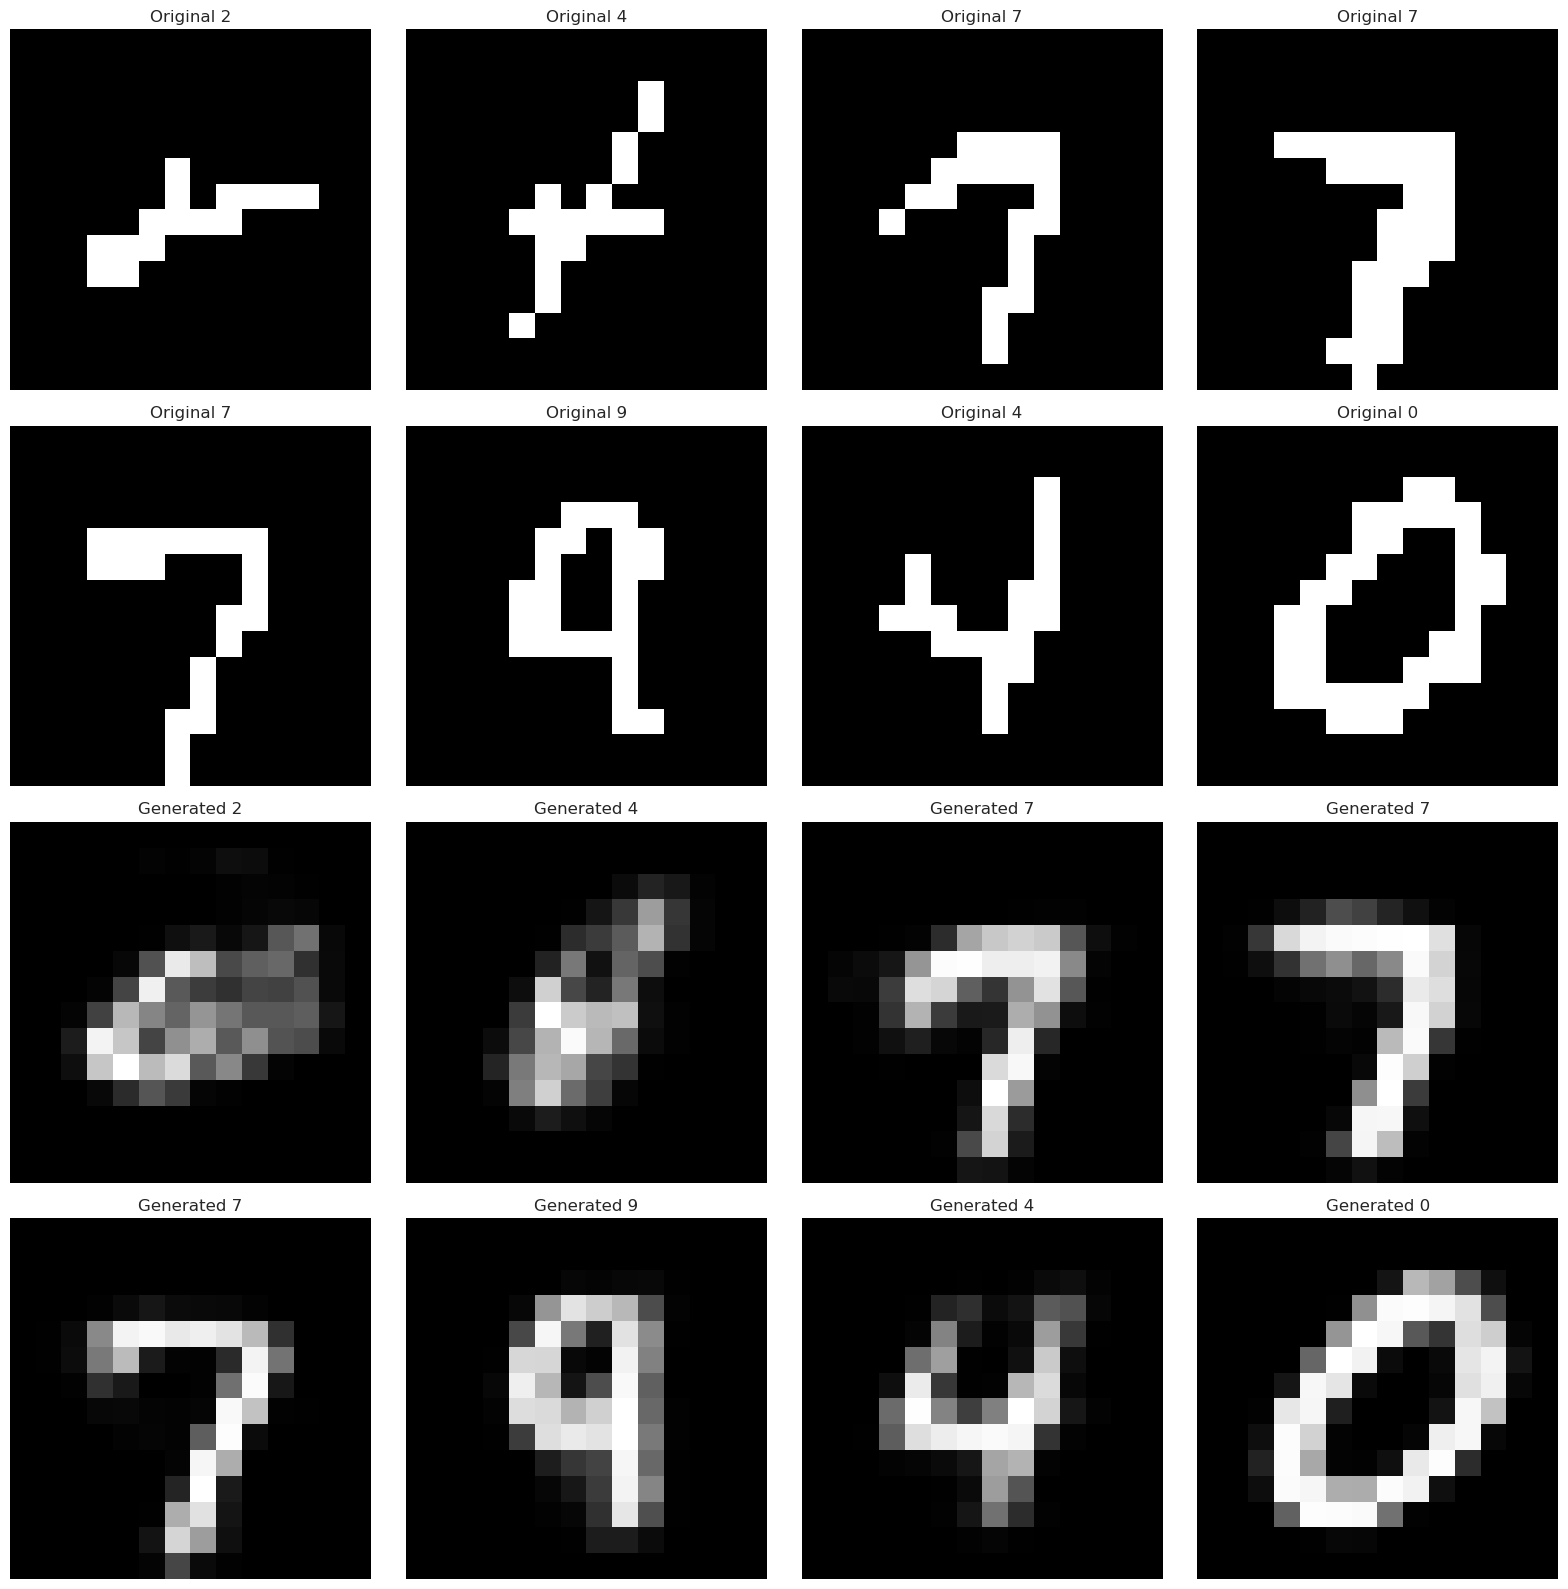

In [7]:
images, labels = next(iter(dataloader))
images = images[:8]; labels = labels[:8]


generated_images, _, _ = VariationalAE(images)
images = images.detach().numpy()
generated_images = generated_images.detach().numpy()

# Plot the original and reconstructed images side by side
fig, axs = plt.subplots(4, 4, figsize=(16, 16))
for i in range(8):
    # Original images
    axs[i//4, i%4].imshow(images[i].reshape(14, 14), cmap='gray')
    axs[i//4, i%4].set_title(f'Original {int(labels[i])}')
    axs[i//4, i%4].axis('off')
    # Reconstructed images
    axs[(i+8)//4, (i+8)%4].imshow(generated_images[i].reshape(14, 14), cmap='gray')
    axs[(i+8)//4, (i+8)%4].set_title(f'Generated {int(labels[i])}')
    axs[(i+8)//4, (i+8)%4].axis('off')

plt.tight_layout()
plt.show()

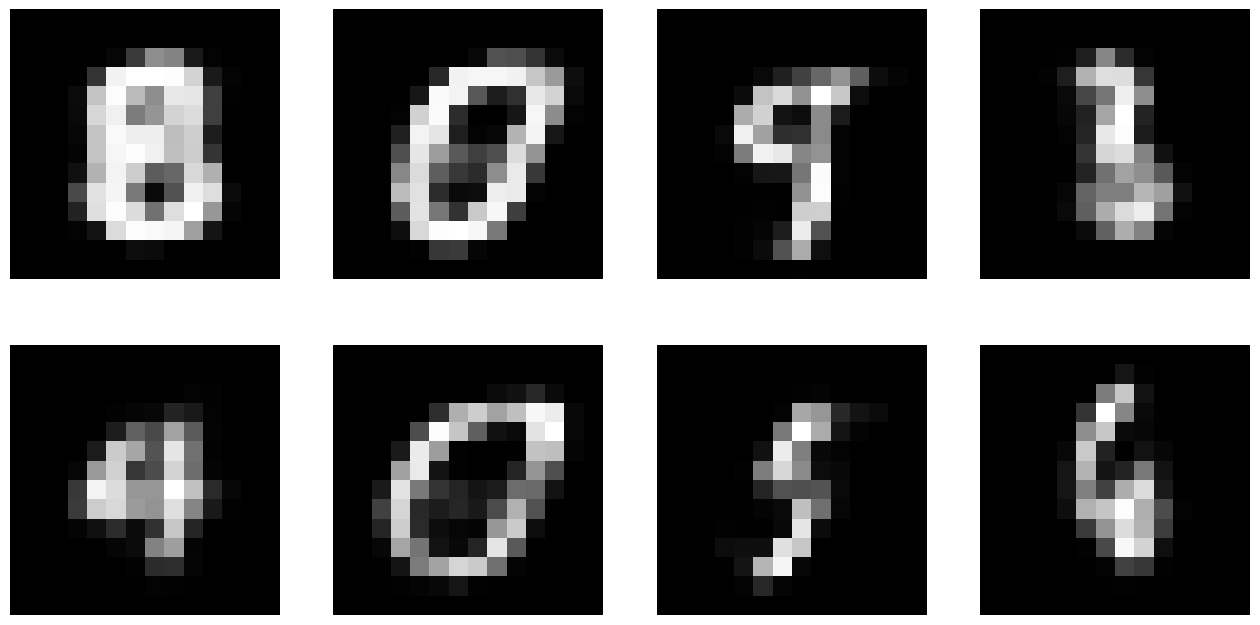

In [8]:
"""Sampling from the latent space"""
fig, axs = plt.subplots(2, 4, figsize=(16, 8))

# Sample z from a standard Gaussian distribution
z = torch.randn(8, 8)

# Run the decoder network to synthesize an image
syn_images = VariationalAE.decode(z)

# Convert the synthesized images to numpy arrays
syn_images = syn_images.detach().numpy()

# Plot the synthesized images
for i in range(8):
    axs[i//4, i%4].imshow(syn_images[i].reshape(14, 14), cmap='gray')
    axs[i//4, i%4].axis('off')

plt.show()

In [9]:
val_dataloader = DataLoader(valdata, batch_size=100, shuffle=True)

def validate(VariationalAE, dataloader):
    VariationalAE.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in (dataloader):
            data = batch[0]
            recon_batch, mu, logvar = VariationalAE(data)
            BCE, KLD = loss_function(recon_batch, data, mu, logvar)
            val_loss += BCE.item() + KLD.item()
    return val_loss / len(dataloader.dataset)

all_train_losses = []
all_val_losses = []
update_count = 0

for epoch in range(1, 51):
    for batch in (dataloader):
        data = batch[0]
        optimizer.zero_grad()
        recon_batch, mu, logvar = VariationalAE(data)
        BCE, KLD = loss_function(recon_batch, data, mu, logvar)
        loss = BCE + KLD
        loss.backward()
        optimizer.step()
        
        all_train_losses.append(BCE.item()/len(dataloader))
        
        update_count += 1
        if update_count % 100 == 0:
            val_loss = validate(VariationalAE, val_dataloader)
            all_val_losses.append(val_loss/len(val_dataloader))

In [ ]:
plt.subplot(2, 1, 1)
plt.plot(all_train_losses[:-50], label='Train Loss')  # Exclude the last value
plt.title("Training Loss")
plt.xlabel("Weight Update")
plt.ylabel("Loss")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(range(0, len(all_train_losses[:-50]), 100), all_val_losses, label='Validation Loss')
plt.title("Validation Loss")
plt.xlabel("Weight Update")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.savefig("Training_Validation_Loss.png")
plt.show()